In [1]:
#pip install opencv-python numpy pandas scikit-learn tensorflow matplotlib pillow

In [ ]:
#pip install roboflow                                                         



In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key="ZmW873Recc4wX7ISKftX")


project = rf.workspace("tea-dataset-w9n3c").project("tea-leaves-dataset")

dataset = project.version(1).download("coco")  

print("Download complete! Dataset path:", dataset.location)

loading Roboflow workspace...
loading Roboflow project...
Download complete! Dataset path: e:\Tea Project\Tea-Leaves-Dataset-1


In [3]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2


In [4]:
test_annotation_path = "Tea-Leaves-Dataset-1/train/_annotations.coco.json"

# Load COCO JSON
with open(test_annotation_path, 'r') as f:
    coco_data = json.load(f)

# Count number of images
num_test_images = len(coco_data['images'])
print(f"Number of images in the test dataset: {num_test_images}")


Number of images in the test dataset: 1766


In [5]:

label_mapping = {
    "T1": "FTGFOP",
    "T2": "GFOP",
    "T3": "OP",
    "T4": "Reject"
}

# === Path to annotation files ===
annotation_files = [
    "tea-leaves-dataset-1/train/_annotations.coco.json",
    "tea-leaves-dataset-1/valid/_annotations.coco.json",
    "tea-leaves-dataset-1/test/_annotations.coco.json"
]

for file_path in annotation_files:
    if not os.path.exists(file_path):
        continue
    
    with open(file_path, "r") as f:
        data = json.load(f)

    # Map old category names to new ones
    for category in data["categories"]:
        old_name = category["name"]
        if old_name in label_mapping:
            category["name"] = label_mapping[old_name]

    # Save changes
    with open(file_path, "w") as f:
        json.dump(data, f, indent=4)



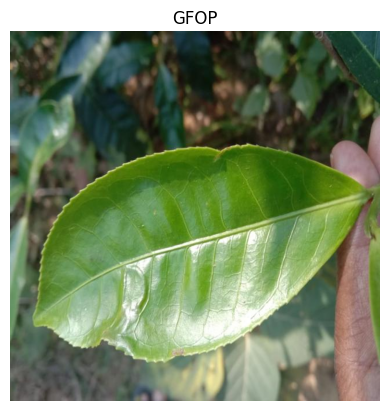

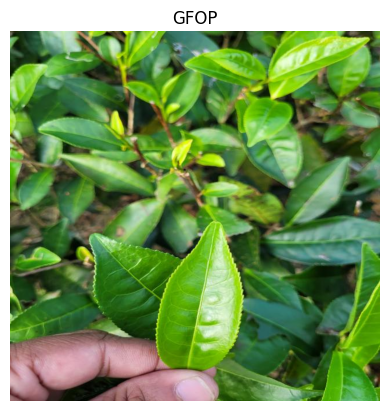

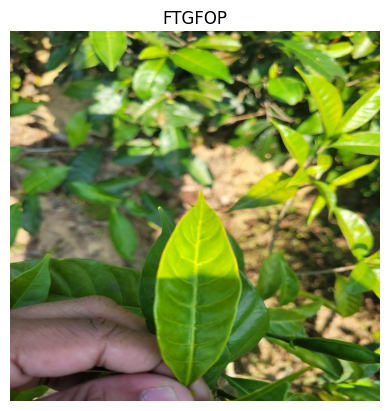

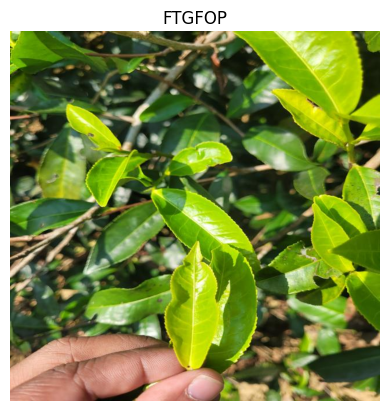

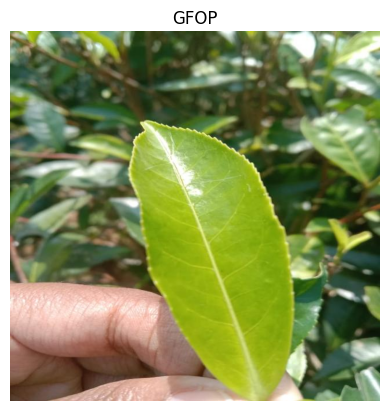

In [6]:
import os
import json
import cv2
import matplotlib.pyplot as plt

# Path to test set
subset_path = "Tea-Leaves-Dataset-1/train"
json_path = os.path.join(subset_path, "_annotations.coco.json")

# Load JSON
with open(json_path, "r") as f:
    coco_data = json.load(f)

# Build image_id → filename
id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}

# Build category_id → label name
id_to_category = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

# Build filename → list of label names
filename_to_labels = {}
for ann in coco_data["annotations"]:
    img_id = ann["image_id"]
    cat_id = ann["category_id"]
    filename = id_to_filename[img_id]
    label = id_to_category[cat_id]

    if filename not in filename_to_labels:
        filename_to_labels[filename] = []
    filename_to_labels[filename].append(label)

# Display images with labels (limit to first 5 for demo)
for idx, (filename, labels) in enumerate(filename_to_labels.items()):
    if idx >= 5:
        break
    image_path = os.path.join(subset_path, filename)
    image = cv2.imread(image_path)
    if image is None:
        continue

    # Convert to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display
    plt.imshow(image_rgb)
    plt.title(", ".join(set(labels)))  # Unique labels
    plt.axis('off')
    plt.show()


In [7]:
def preprocess_image(image_path, size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img, img_hsv



In [8]:
dataset_path = "E:\Tea Project\Tea-Leaves-Dataset-1"
subsets = ["train", "valid", "test"]

all_images = {
    "train": [],
    "valid": [],
    "test": []
}

label_dicts = {}  # NEW: To store label dicts per subset

def build_coco_label_dict(coco_data):
    id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}
    id_to_category = {cat["id"]: cat["name"] for cat in coco_data["categories"]}
    
    filename_to_labels = {}
    for ann in coco_data["annotations"]:
        image_id = ann["image_id"]
        category_id = ann["category_id"]
        
        filename = id_to_filename.get(image_id)
        category = id_to_category.get(category_id)
        
        if filename and category:
            if filename not in filename_to_labels:
                filename_to_labels[filename] = []
            filename_to_labels[filename].append(category)
    
    return filename_to_labels

for subset in subsets:
    subset_path = os.path.join(dataset_path, subset)
    label_path = os.path.join(subset_path, "_annotations.coco.json")

    if not os.path.exists(subset_path) or not os.path.exists(label_path):
        print(f"Skipping {subset}: Missing folder or _annotations.coco.json")
        continue

    with open(label_path, "r") as f:
        coco_data = json.load(f)

    label_dict = build_coco_label_dict(coco_data)
    label_dicts[subset] = label_dict  # store per subset

    for filename in os.listdir(subset_path):
        if filename.lower().endswith((".jpg", ".png", ".jpeg")):
            image_path = os.path.join(subset_path, filename)
            img_bgr, img_hsv = preprocess_image(image_path)

            if filename in label_dict:
                all_images[subset].append((img_bgr, filename))
            #else:
                #print(f"Warning: No label found for {filename} in {subset}/_annotations.coco.json")

print("✅ All subsets loaded with labels and images.")


✅ All subsets loaded with labels and images.


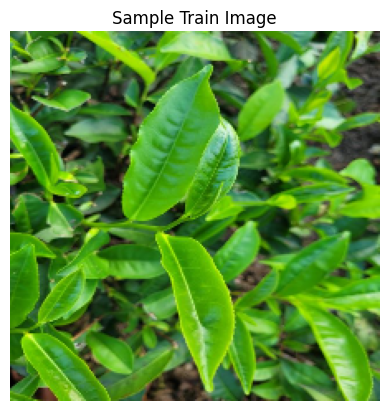

In [9]:
img_bgr, img_hsv = all_images["train"][1]

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Sample Train Image")
plt.axis('off')
plt.show()

In [10]:
all_images["train"][0][0].shape # Example to check the shape of the first image in the train set

(224, 224, 3)

In [11]:
import tensorflow as tf


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

dataset_dir = "tea-leaves-dataset-1"
subdirs = ['train', 'valid', 'test']

def extract_cnn_features(img):
    img = cv2.resize(img, (224, 224))  # Already done earlier, but safe to keep
    img = preprocess_input(img.astype(np.float32))
    features = model.predict(np.expand_dims(img, axis=0), verbose=0)
    return features.flatten()
#def extract_cnn_features(img_bgr, model):
    #try:
        #img = preprocess_image(img_bgr)
        #img = np.expand_dims(img, axis=0)
        #features = model.predict(img, verbose=0)
        #return features.flatten()
   # except Exception as e:
       # raise ValueError(f"Feature extraction failed: {e}")



`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


In [13]:
def extract_data(image_list, label_dict, multi_label=False):
    features = []
    labels = []

    for img_bgr, filename in image_list:
        feat = extract_cnn_features(img_bgr)
        features.append(feat)

        label = label_dict.get(filename)

        if label is None or len(label) == 0:
            print(f"Warning: No label found for {filename}")
            continue

        if multi_label:
            labels.append(label)  # Keep full list
        else:
            labels.append(label[0])  # Just take the first label
    return np.array(features), np.array(labels, dtype=object if multi_label else str)

In [16]:
X_train, y_train = extract_data(all_images["train"], label_dicts["train"], multi_label=False) 
X_test, y_test = extract_data(all_images["test"], label_dicts["test"], multi_label=False)
X_valid, y_valid = extract_data(all_images["valid"], label_dicts["valid"], multi_label=False)

In [27]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import StandardScaler

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)
y_test_encoded  = le.transform(y_test)


# === Tune SVM on Validation Set ===
best_score = 0
best_model = None
best_params = {}


In [28]:
from sklearn.metrics import classification_report, f1_score
print("\n Tuning SVM with validation set...\n")
for C in [0.1, 1, 10, 100]:
    for gamma in ['scale', 0.01, 0.001]:
        clf = SVC(kernel='rbf', C=C, gamma=gamma)
        clf.fit(X_train, y_train_encoded)
        y_val_pred = clf.predict(X_valid)
        score = f1_score(y_valid_encoded, y_val_pred, average='macro')
        print(f"C={C}, gamma={gamma}, f1_macro={score:.4f}")
        if score > best_score:
            best_score = score
            best_model = clf
            best_params = {'C': C, 'gamma': gamma}

print("\n Best Parameters:", best_params)


 Tuning SVM with validation set...

C=0.1, gamma=scale, f1_macro=0.3941
C=0.1, gamma=0.01, f1_macro=0.0000
C=0.1, gamma=0.001, f1_macro=0.3443
C=1, gamma=scale, f1_macro=0.6490
C=1, gamma=0.01, f1_macro=0.5497
C=1, gamma=0.001, f1_macro=0.6389
C=10, gamma=scale, f1_macro=0.6789
C=10, gamma=0.01, f1_macro=0.5807
C=10, gamma=0.001, f1_macro=0.6761
C=100, gamma=scale, f1_macro=0.6789
C=100, gamma=0.01, f1_macro=0.5807
C=100, gamma=0.001, f1_macro=0.6617

 Best Parameters: {'C': 10, 'gamma': 'scale'}


In [29]:
y_test_pred_encoded = best_model.predict(X_test)
y_test_pred = le.inverse_transform(y_test_pred_encoded)
y_test_true = le.inverse_transform(y_test_encoded)

print("\n Final Test Set Performance:\n")
print(classification_report(y_test_true, y_test_pred))


 Final Test Set Performance:

              precision    recall  f1-score   support

      FTGFOP       0.91      0.89      0.90        54
        GFOP       0.72      0.82      0.77        61
          OP       0.85      0.76      0.80        51
      Reject       0.92      0.89      0.90        53

    accuracy                           0.84       219
   macro avg       0.85      0.84      0.84       219
weighted avg       0.85      0.84      0.84       219



In [30]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# === 1. Load MobileNetV2 (same as training)
model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# === 2. Image Preprocessing Function
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img.astype(np.float32))
    return img

# === 3. Feature Extraction (MobileNetV2)
def extract_features_from_image(image_path):
    img = load_and_preprocess_image(image_path)
    features = model.predict(np.expand_dims(img, axis=0), verbose=0)
    return features.flatten()

# === 4. Predict Function (No Normalization)
def predict_image(image_path, model, label_encoder):
    feature = extract_features_from_image(image_path)
    pred_encoded = model.predict([feature])  # Keep 2D shape
    pred_label = label_encoder.inverse_transform(pred_encoded)
    return pred_label[0]

# === 5. Show Prediction on Image (with label)
def show_prediction(image_path, model, label_encoder):
    pred = predict_image(image_path, model, label_encoder)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title(f"Predicted: {pred}")
    plt.axis('off')
    plt.show()


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


In [31]:
import joblib

# Save model
joblib.dump(best_model, "tea_model.pkl")

# Save label encoder
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

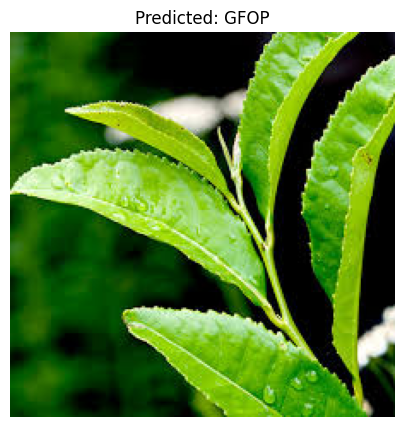

In [33]:
# Load model and label encoder
best_model = joblib.load("tea_model.pkl")
le = joblib.load("label_encoder.pkl")

predict_image("tea_leaf.jpg", best_model, le)
show_prediction("tea_leaf.jpg", best_model, le)
